In [1]:
import os
import numpy as np
import scipy.stats as sps
import pickle
from utils import mult_diag
import cortex

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
alpha_range = range(0, 500, 5)
#result_folder = 'result4'
result_folder = 'results/sub3/0_500_prep3/'

In [3]:
import os
#fresults = os.listdir('result_sub1_alprange_0_180/')
fresults = os.listdir(result_folder)
print len(fresults)

23100


In [4]:
def get_result(filename):
    try:
        return np.load(result_folder + '/' + filename)
    except Exception as e:
        print e
        return

In [5]:
#res = map(get_result, fgood_voxels)
res = map(get_result, fresults)

In [6]:
res = np.array(res)

In [7]:
res[788][0]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, -0.02739301, -0.01325985,
       -0.15351365,  0.02980823,  0.05630283,  0.02300758, -0.08894227,
       -0.00133927,  0.05823984,  0.02793841,  0.03173931,  0.11844224,
        0.04199752, -0.00864828,  0.03506495,  0.13243771,  0.18633931,
               nan,         nan,  0.04351694,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan])

a,np.mean(Rcorr),np.max(Rcorr),np.min(Rcorr), corrmin,\
                       (Rcorr>corrmin).sum(), (-Rcorr>corrmin).sum()

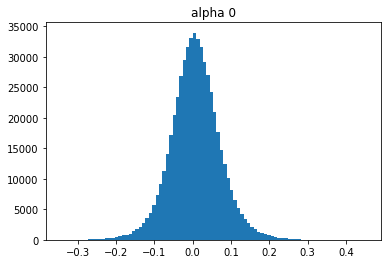

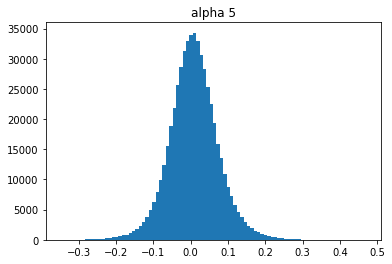

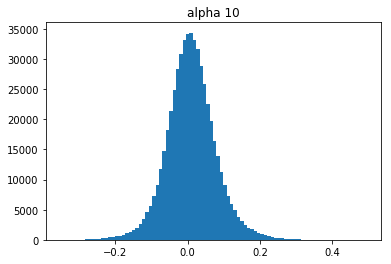

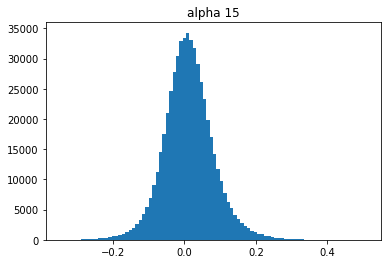

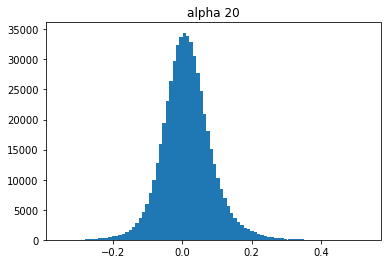

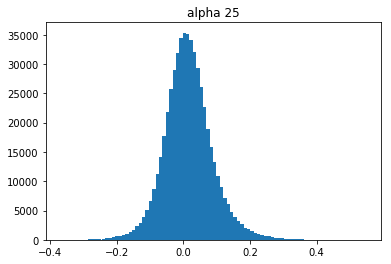

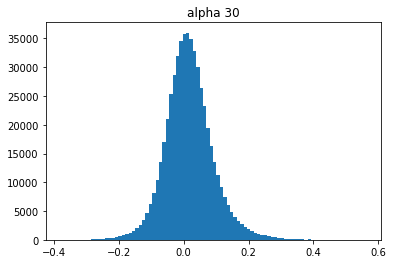

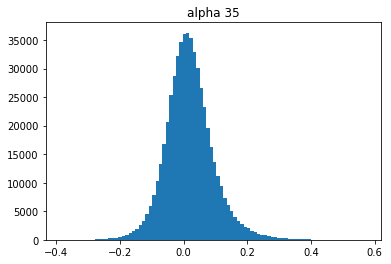

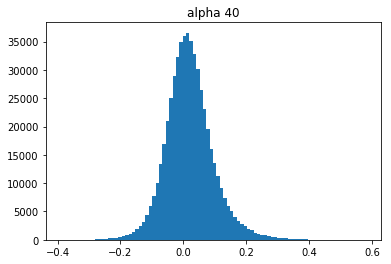

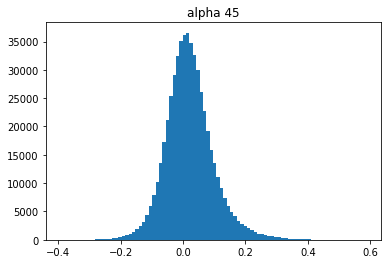

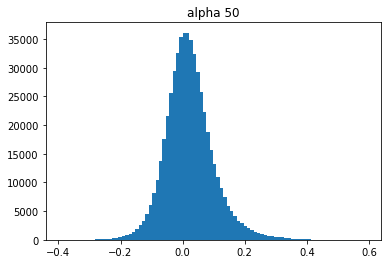

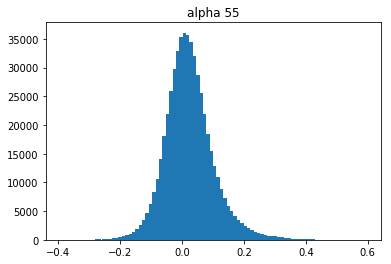

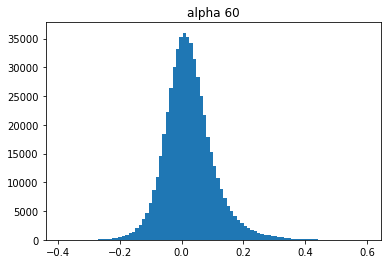

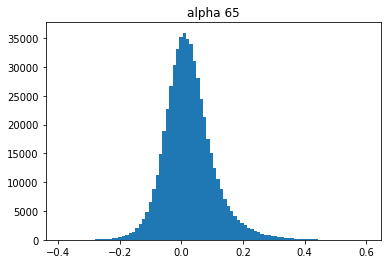

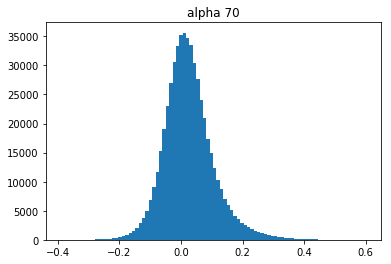

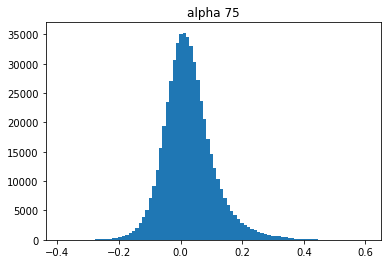

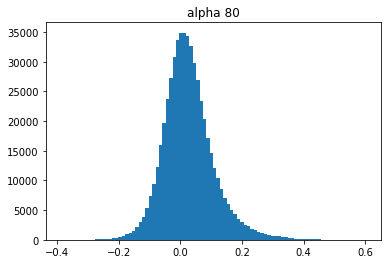

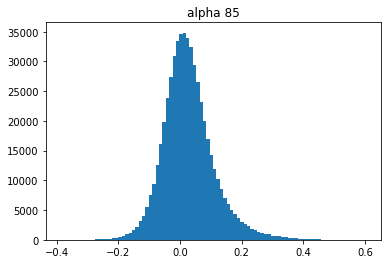

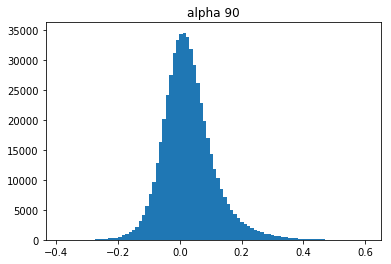

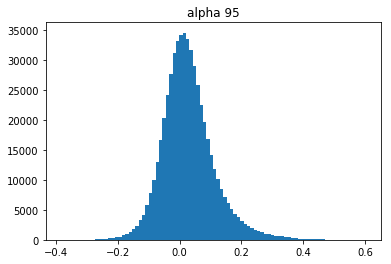

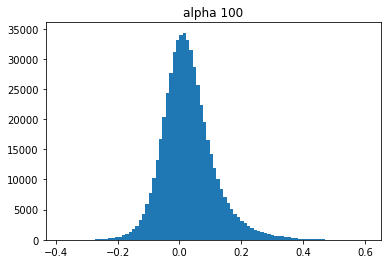

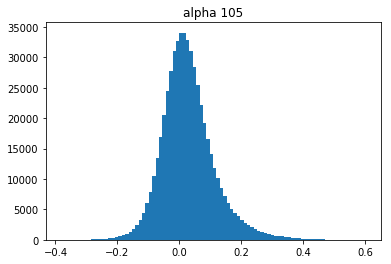

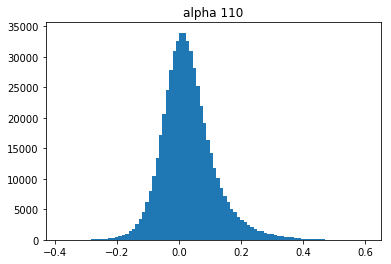

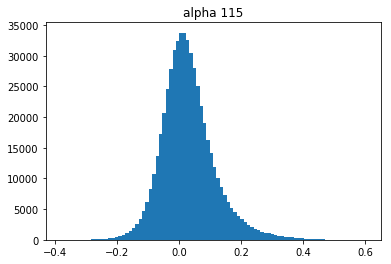

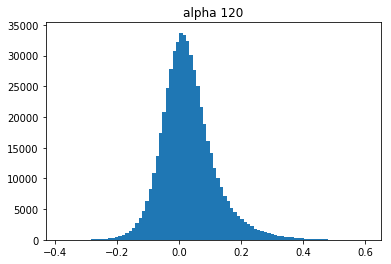

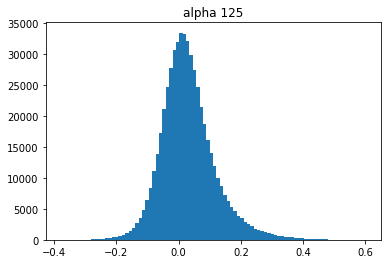

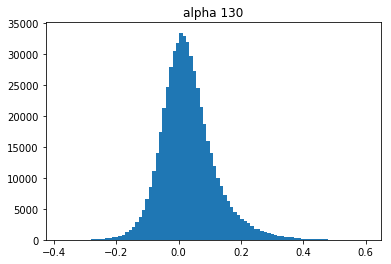

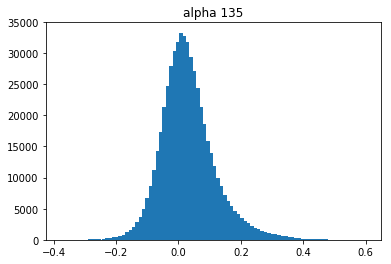

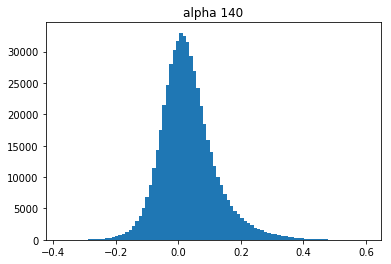

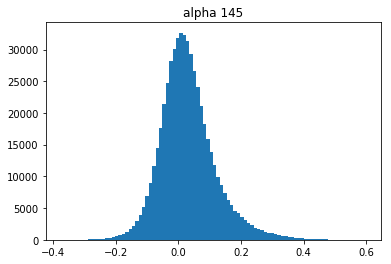

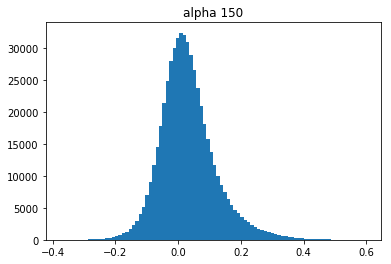

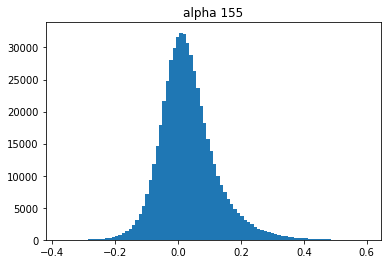

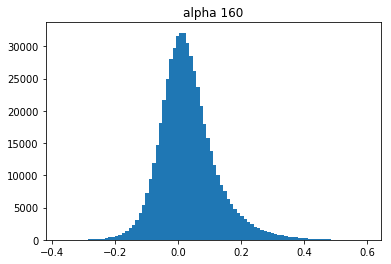

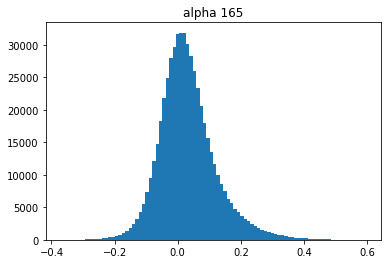

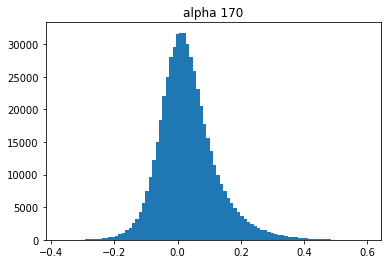

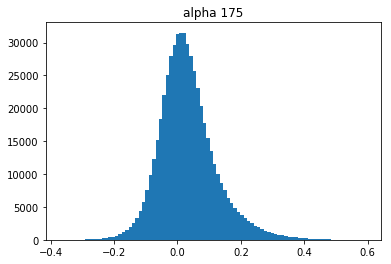

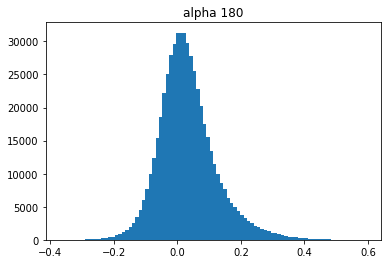

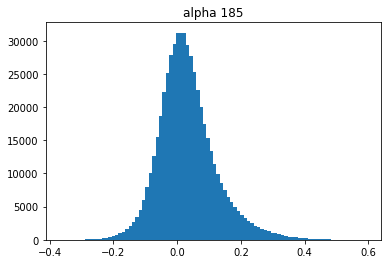

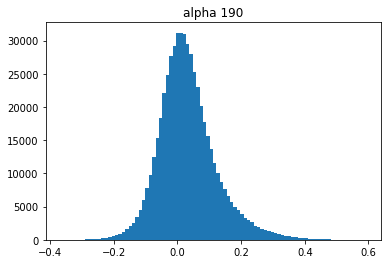

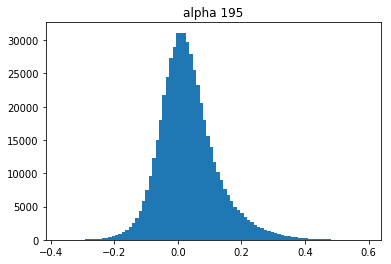

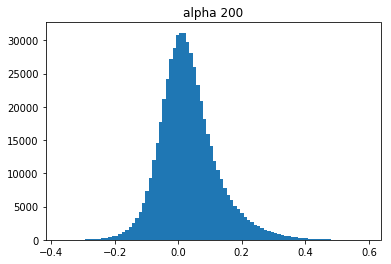

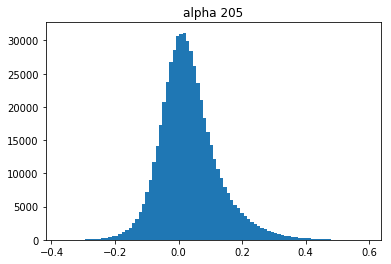

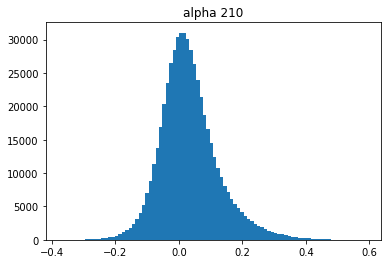

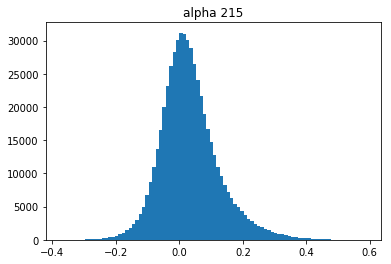

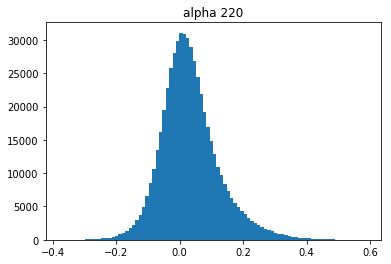

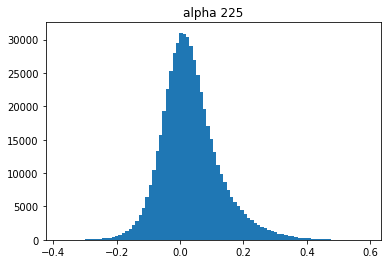

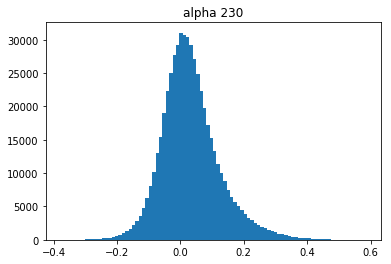

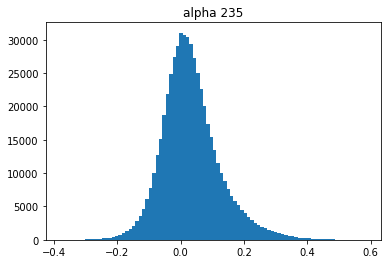

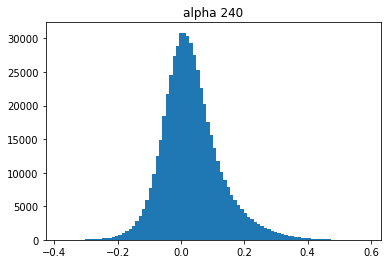

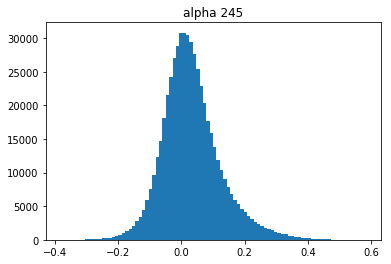

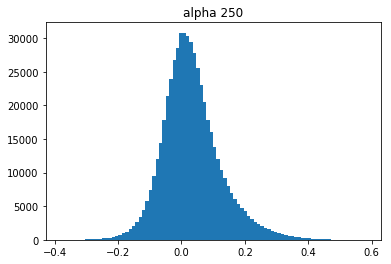

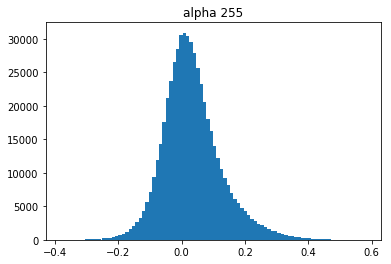

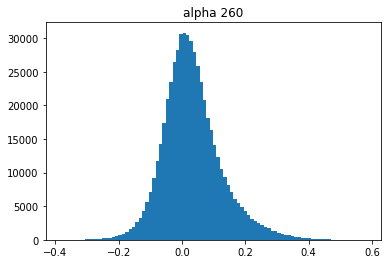

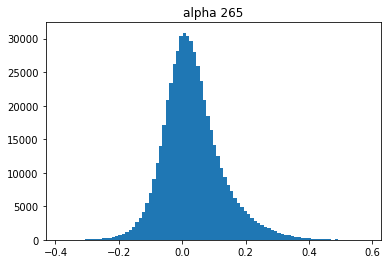

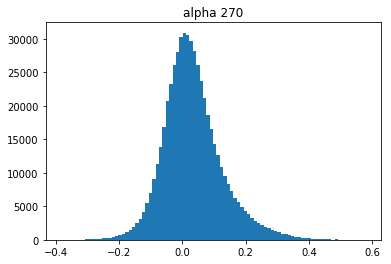

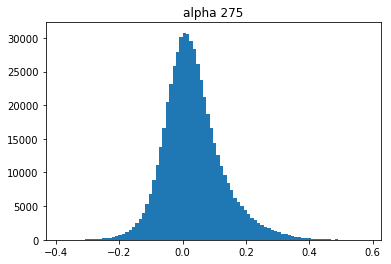

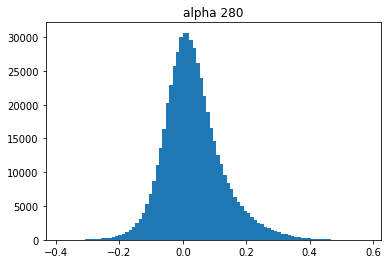

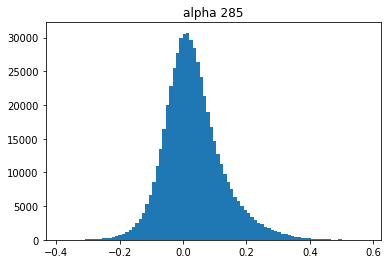

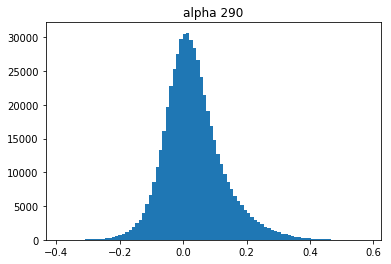

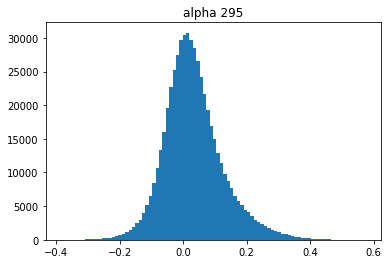

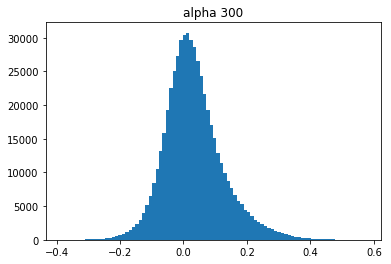

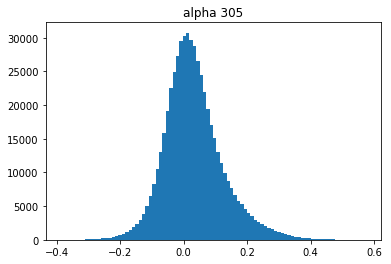

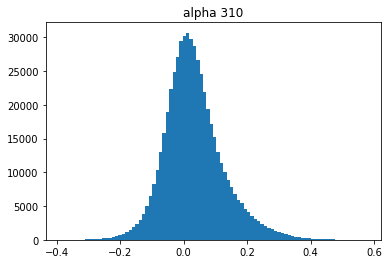

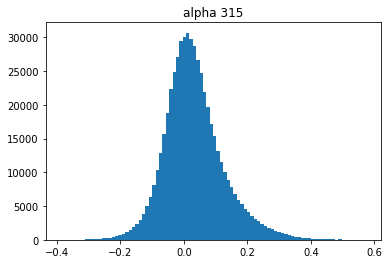

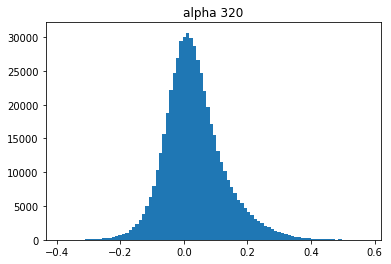

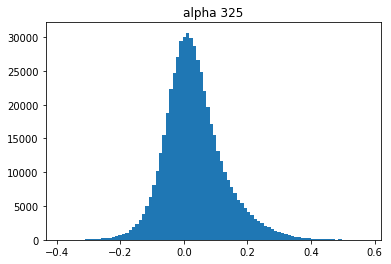

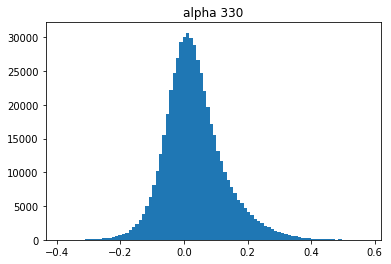

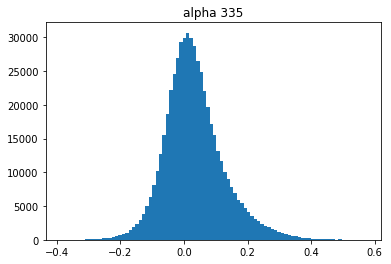

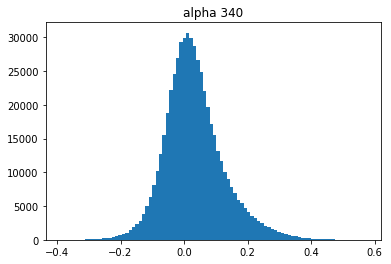

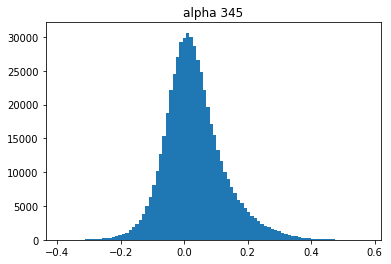

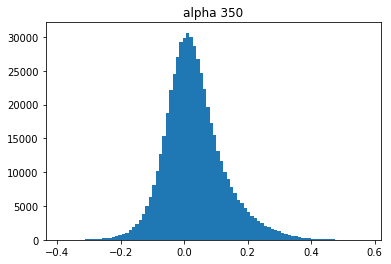

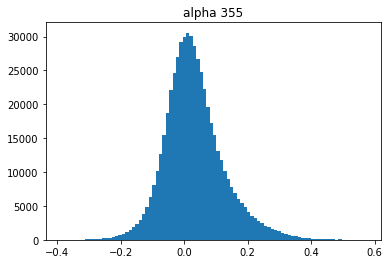

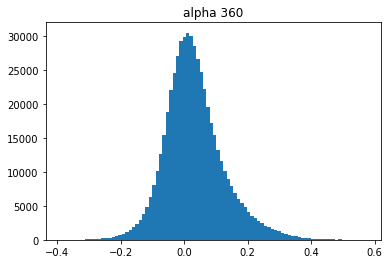

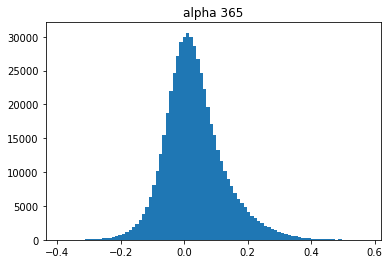

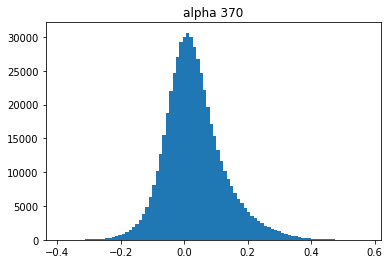

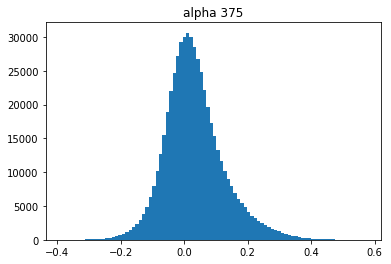

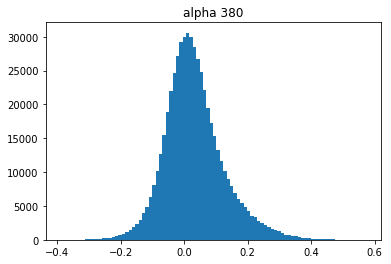

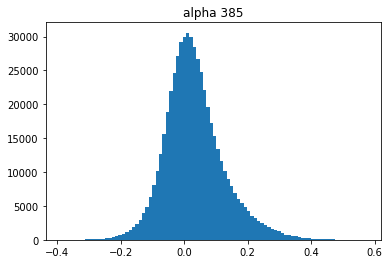

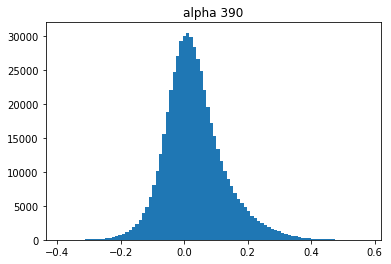

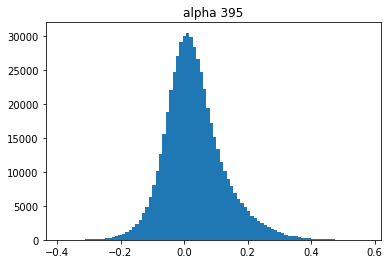

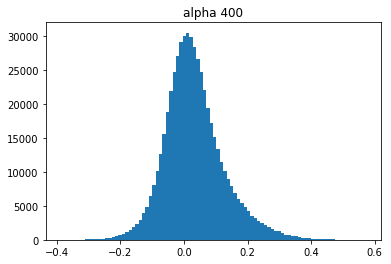

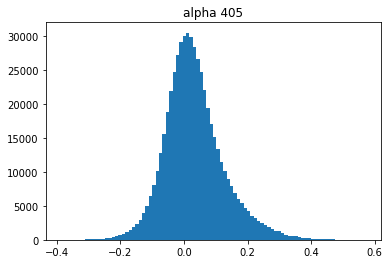

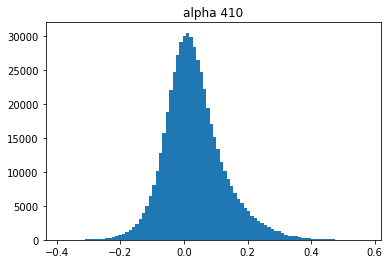

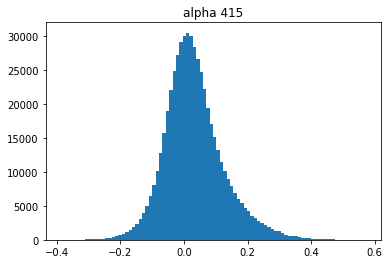

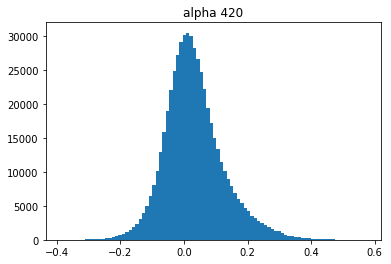

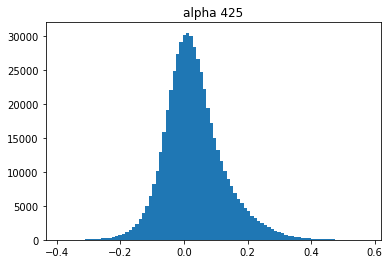

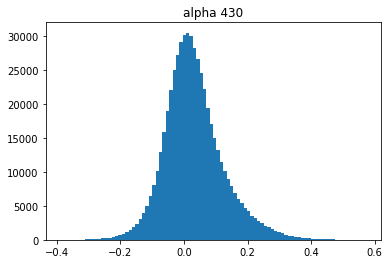

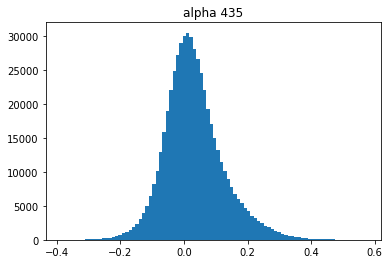

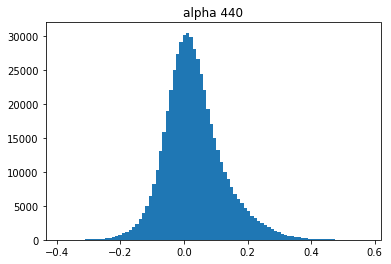

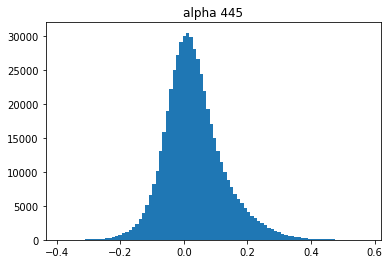

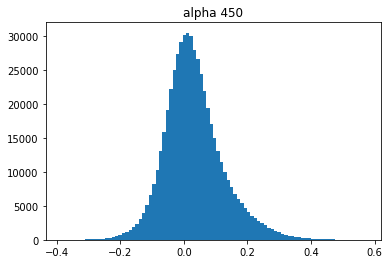

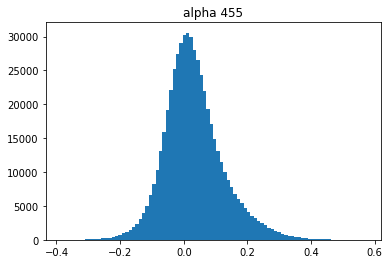

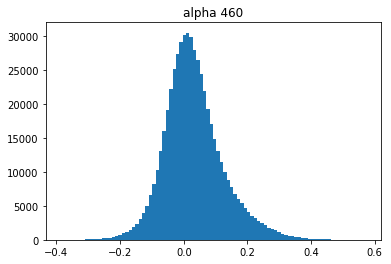

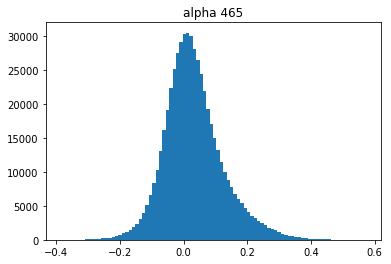

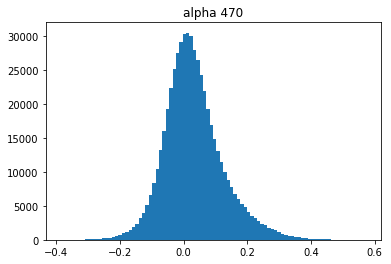

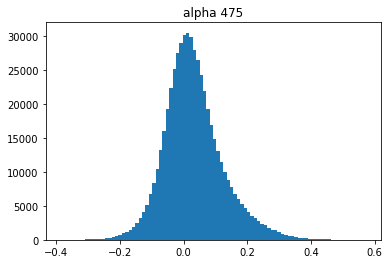

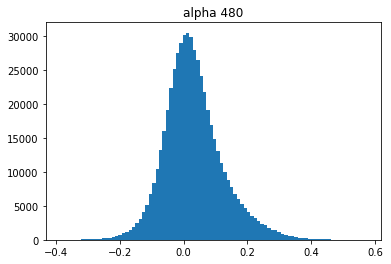

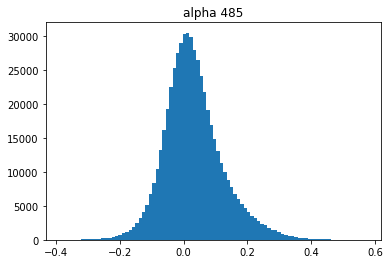

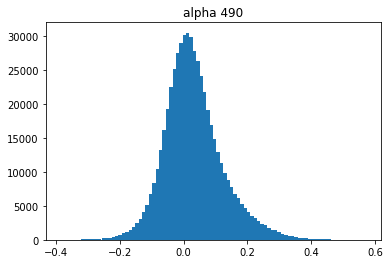

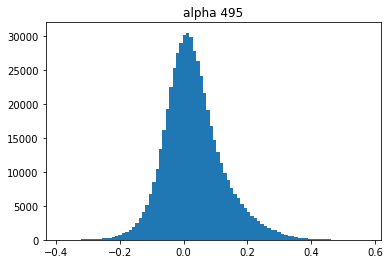

In [9]:
#figure(figsize=(10,10))
alp_score = list()
mean_score = list()
max_score = list()
min_score = list()

for n, alpha in enumerate(alpha_range):
    X = res[:, n]
    X2 = X[~np.isnan(X)]
    
    title("alpha {}".format(alpha))
    hist(X2, bins=90, label=str(alpha))
    alp_score.append((X2 > 0.2).sum() - (X2 < -0.2).sum())
    min_score.append(X2.min())
    max_score.append(X2.max())
    mean_score.append(X2.mean())
    show()

#legend()
#show()

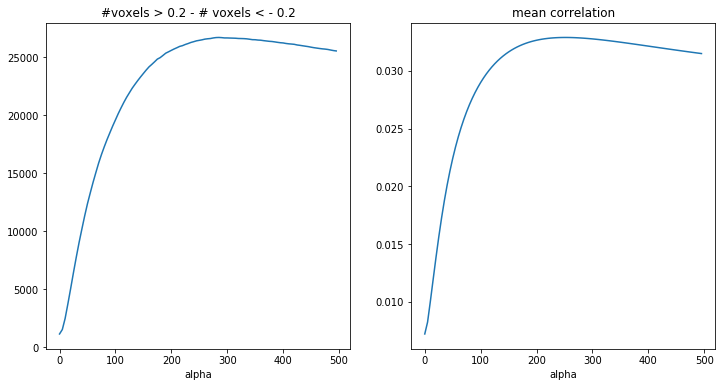

In [10]:
f, axs = subplots(1, 2, figsize=(12,6))
axs[0].plot(alpha_range, np.array(alp_score))
axs[0].set_title("#voxels > 0.2 - # voxels < - 0.2")
axs[0].set_xlabel('alpha')
axs[1].plot(alpha_range, mean_score)
#axs[1].fill_between(alpha_range, min_score, max_score, alpha=0.2)
axs[1].set_title('mean correlation')
axs[1].set_xlabel('alpha')

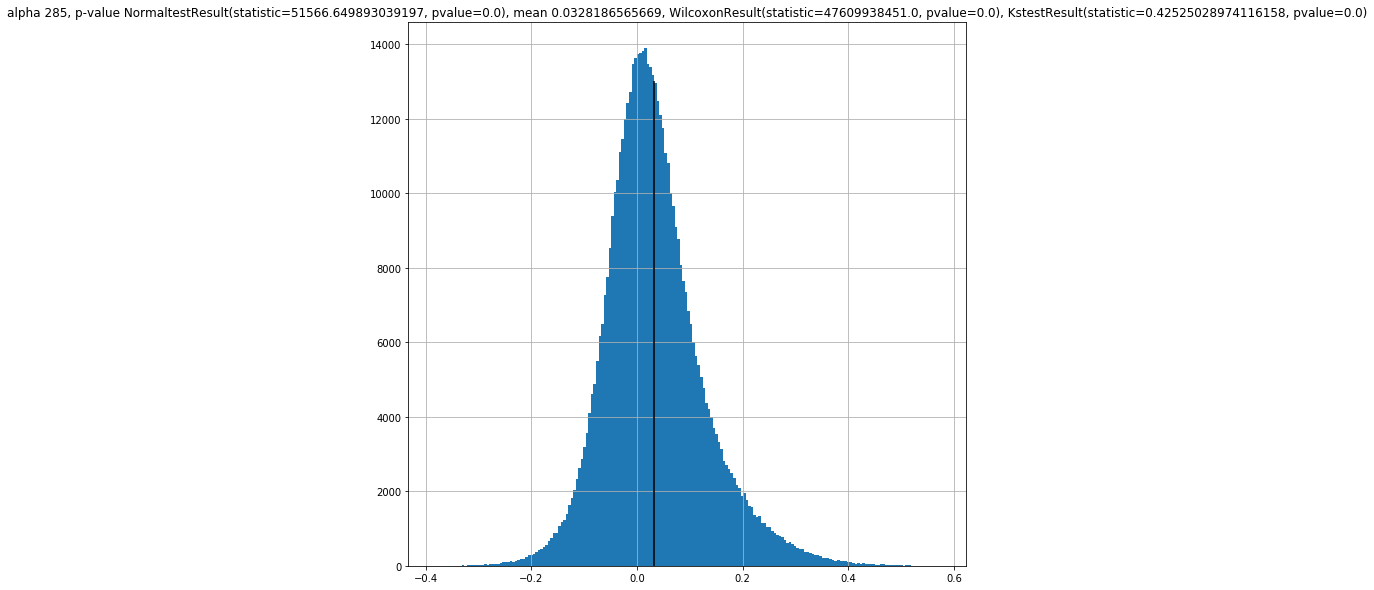

In [12]:
alpha=alpha_range[np.argmax(alp_score)]
n = alpha_range.index(alpha)
X = res[:, n, :]
X = X[~np.isnan(X)]

figure(figsize=(10,10))
title("alpha {}, p-value {}, mean {}, {}, {}".format(str(alpha), 
                                                     sps.mstats.normaltest(X), 
                                                     np.mean(X), 
                                                     sps.wilcoxon(X.ravel()), 
                                                     sps.kstest(X.ravel(), 'norm')))
grid()
hist(X, bins=200, label=str(alpha))
vlines(np.mean(X), ymin=0, ymax=13000)
show()

In [13]:
X = res[:, n] * (res[:, n] > 0)
res_pair = map(lambda x: x[:-4].split('_'), fresults)
res_pair = map(lambda x: [int(x[0]), int(x[1])], res_pair)

res = np.zeros((132, 175, 48))

for i, [x, y] in enumerate(res_pair):
    res[x,y,:] = X[i]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [76]:
np.save('results/sub3/alph285_mask', res)

In [17]:
res = np.nan_to_num(res)

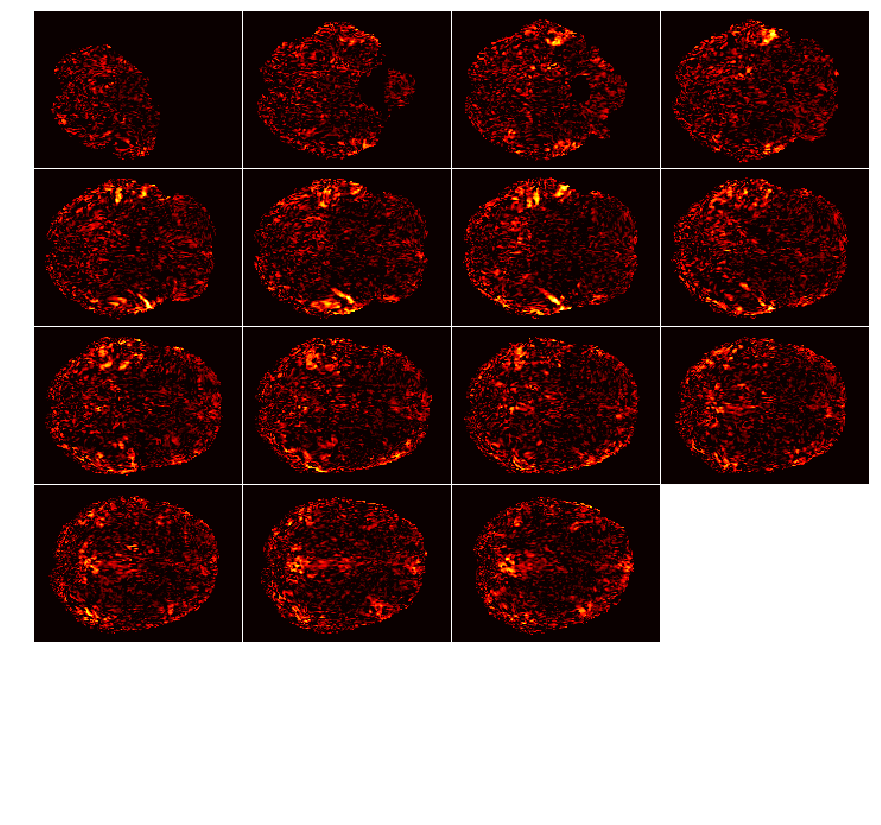

In [59]:
f = figure(figsize=(15,15))
c = cortex.mosaic(res[:, :, 5::3], dim=2,  vmin=0, vmax=0.6, cmap='hot')
#colorbar(orientation='horizontal')

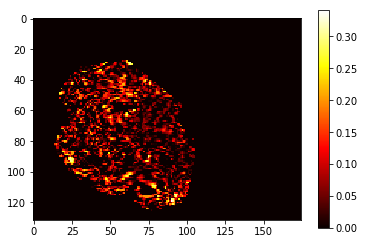

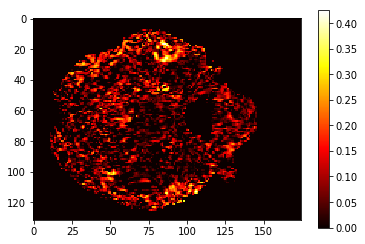

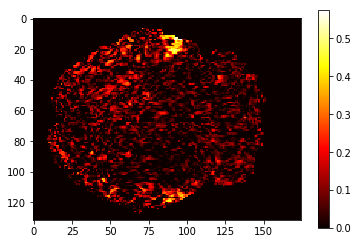

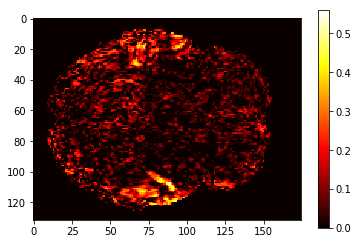

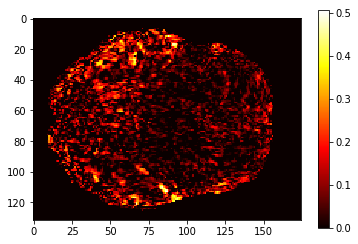

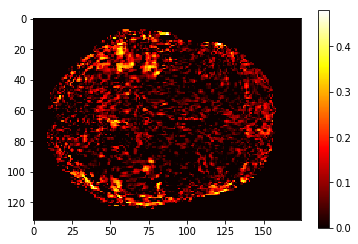

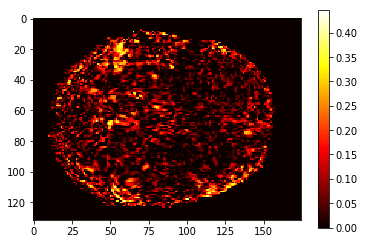

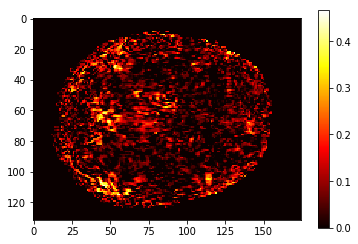

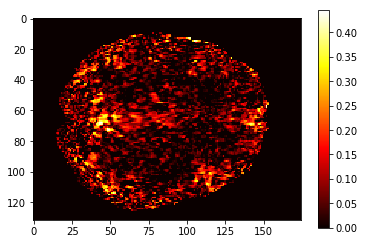

In [15]:
for z in [5,10,15,20,25,30,35,40,45]:
    imshow(res[:,:,z], cmap='hot')
    colorbar()
    show()

In [17]:
with open("srt/stimulus.pcl", 'rb') as f:
    stimulus = pickle.load(f)

In [18]:
mri = np.load("fmri/mri_all1_preprocessed.npy")

In [23]:
zs = lambda v: (v-v.mean(0))/v.std(0) ## z-score function

def get_prediction(Rstim, Pstim, Rresp, alpha, singcutoff=1e-10):
    ## Precompute some products for speed
    try:
        U,S,Vh = np.linalg.svd(Rstim, full_matrices=False)
    except np.linalg.LinAlgError, e:
        #logger.info("NORMAL SVD FAILED, trying more robust dgesvd..")
        from text.regression.svd_dgesvd import svd_dgesvd
        U,S,Vh = svd_dgesvd(Rstim, full_matrices=False)

    origsize = S.shape[0]
    ngoodS = np.sum(S>singcutoff)
    nbad = origsize-ngoodS
    U = U[:,:ngoodS]
    S = S[:ngoodS]
    Vh = Vh[:ngoodS]
    
    UR = np.dot(U.T, Rresp)
    PVh = np.dot(Pstim, Vh.T)
    
    D = S/(S ** 2 + alpha ** 2) ## Reweight singular vectors by the (normalized?) ridge parameter
    pred = np.dot(mult_diag(D, PVh, left=False), UR) ## Best (1.75 seconds to prediction in test)
    
    return pred

In [24]:
best_voxel = good_voxels[res[:,n,1].argmax()]

In [26]:
pred = get_prediction(stimulus[:-500], stimulus[-500:], mri[best_voxel[0], best_voxel[1], best_voxel[2]][:-500], 180)